In [1]:
#!pip install keras-tuner
#!pip install --upgrade tensorflow

In [2]:
# File and OS operations
import os
import shutil

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.patches as patches

# Image processing
from PIL import Image
from tensorflow.keras.preprocessing import image

# Preprocessing, and TensorFlow/Keras
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import keras_tuner as kt
from tensorflow.keras.models import save_model

# Google Colab operations
from google.colab import files
from google.colab import drive

In [3]:
# mount g drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
drive_path = '/content/drive/MyDrive/AAI-590 Capstone/'

# Indexing Image Directories

In [5]:
df = pd.read_csv(drive_path + 'Data_Entry_2017.csv')

In [6]:
image_paths = {}

for subdir, _, files in os.walk(drive_path):
    for file in files:
        if file.endswith('.png'):
            # Ensure the dictionary key is just the filename
            image_paths[file] = os.path.join(subdir, file)

print(f"Found {len(image_paths)} images.")

Found 112132 images.


In [7]:
df['Image Path'] = df['Image Index'].apply(lambda x: image_paths.get(x))

In [8]:
df.to_csv(drive_path + 'Data_with_image_paths.csv')

# EDA

In [9]:
df = pd.read_csv(drive_path + 'Data_with_image_paths.csv')
df.head()

,Unnamed: 0,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Image Path
0,0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/content/drive/MyDrive/AAI-590 Capstone/images...
1,1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/content/drive/MyDrive/AAI-590 Capstone/images...
2,2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/content/drive/MyDrive/AAI-590 Capstone/images...
3,3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/content/drive/MyDrive/AAI-590 Capstone/images...
4,4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/content/drive/MyDrive/AAI-590 Capstone/images...


## Dataset Overview and Descriptive statistics

In [10]:
print("Number of Rows:", len(df))
print("Number of Unique Images:", df["Image Index"].nunique())
print("Number of Unique Patients:", df["Patient ID"].nunique())

# Utilizing `df.describe()` to generate descriptive statistics for numerical columns.
df.describe()

Number of Rows: 112120
Number of Unique Images: 112120
Number of Unique Patients: 30805


,Unnamed: 0,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,56059.500000,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,32366.400428,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,28029.750000,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,56059.500000,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,84089.250000,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,112119.000000,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


## Filtering and missing data

In [11]:
# Addressing potential age entry errors by removing records with ages above 120 years.
df = df[df['Patient Age'] <= 120]
df.reset_index(drop=True, inplace=True)

In [12]:
# check for NA values
df.isna().sum()

,0
Unnamed: 0,0
Image Index,0
Finding Labels,0
Follow-up #,0
Patient ID,0
Patient Age,0
Patient Gender,0
View Position,0
OriginalImage[Width,0
Height],0


In [13]:
df.drop(columns='Unnamed: 11', inplace=True)

<ipython-input-13-81dd2d83a1dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='Unnamed: 11', inplace=True)


In [14]:
top_labels = ['Infiltration', 'Effusion', 'Atelectasis', 'No Finding']
filtered_df = df[df['Finding Labels'].apply(lambda x: all(label in top_labels for label in x.split('|')))]

def sample_data(df, label, sample_size):
    return df[df['Finding Labels'].str.contains(label)].sample(n=sample_size, random_state=42)

#Sample 5,000 for each disease
infiltration_sampled = sample_data(filtered_df, 'Infiltration', 4000)
effusion_sampled = sample_data(filtered_df, 'Effusion', 4000)
atelectasis_sampled = sample_data(filtered_df, 'Atelectasis', 4000)
no_finding_sampled = sample_data(filtered_df, 'No Finding', 8000)

# Combine the sampled data
combined_sampled_df = pd.concat([infiltration_sampled, effusion_sampled, atelectasis_sampled, no_finding_sampled])
df = combined_sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

## Variable Exploration

### Image index
The 'Image Index' holds valuable information encoded in the file names (e.g., 00000001_000.png). The number preceding the underscore corresponds to the 'Patient ID', while the number after represents the image number for that patient.

In [15]:
print(df["Image Index"][0:5])

0    00025303_012.png
1    00002019_001.png
2    00028924_001.png
3    00019550_014.png
4    00006888_000.png
Name: Image Index, dtype: object


### Target

Key Characteristics:

Multi-label Classification: Images can have "No Finding" or one or more of 14 disease classes (Atelectasis, Consolidation, Infiltration, etc.).

Label Combinations: There are numerous unique combinations of labels, requiring careful handling during model training.

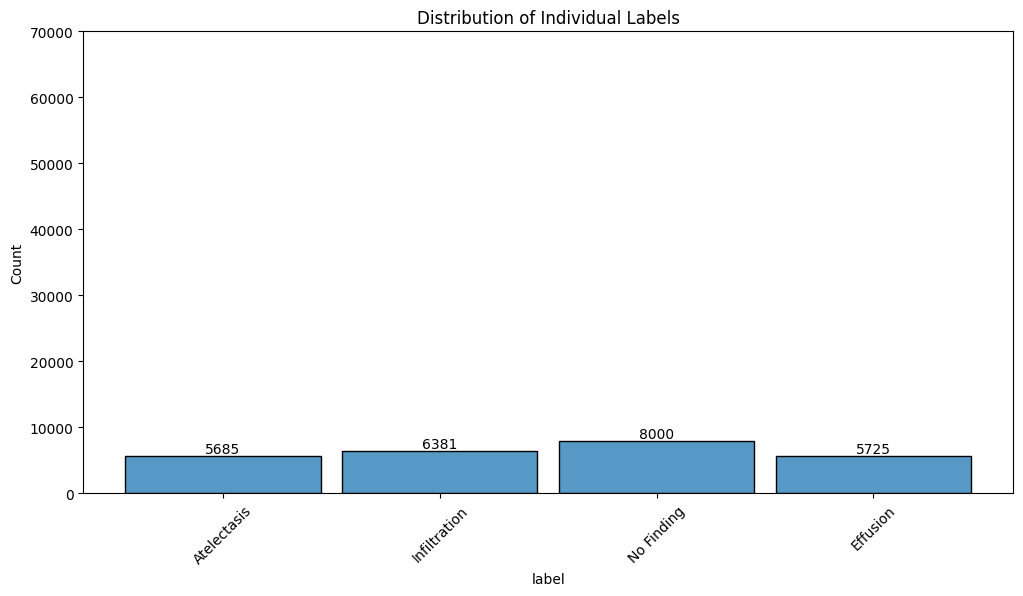

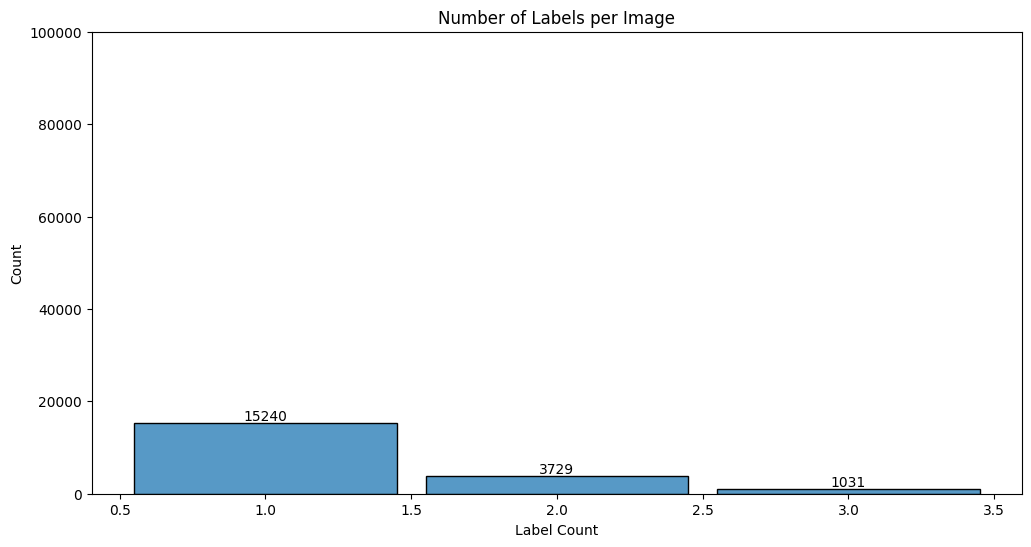

In [16]:
# Splitting labels and counting occurrences
label_counts = df.assign(
    var1=df['Finding Labels'].str.split('|')).explode('var1')["var1"]
label_counts = label_counts.reset_index(drop=True).to_frame()
label_counts.columns = ["label"]

fig, ax = plt.subplots(figsize=(12, 6))
ax.tick_params(axis='x', rotation=45)
sns.histplot(
    label_counts, x="label", discrete=True, ax=ax, shrink=.9).set_title(
        "Distribution of Individual Labels")
ax.bar_label(ax.containers[0])
plt.ylim(0, 70000)
plt.show()

# Analyzing the number of labels per image
labels_per_image = df["Finding Labels"].str.count(r'\|') + 1
labels_per_image = labels_per_image.reset_index(drop=True).to_frame()
labels_per_image.columns = ["Label Count"]

fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(
    labels_per_image,
    x="Label Count",
    discrete=True,
    ax=ax,
    shrink=.9).set_title("Number of Labels per Image")
ax.bar_label(ax.containers[0])
plt.ylim(0, 100000)
plt.show()

### Other Features

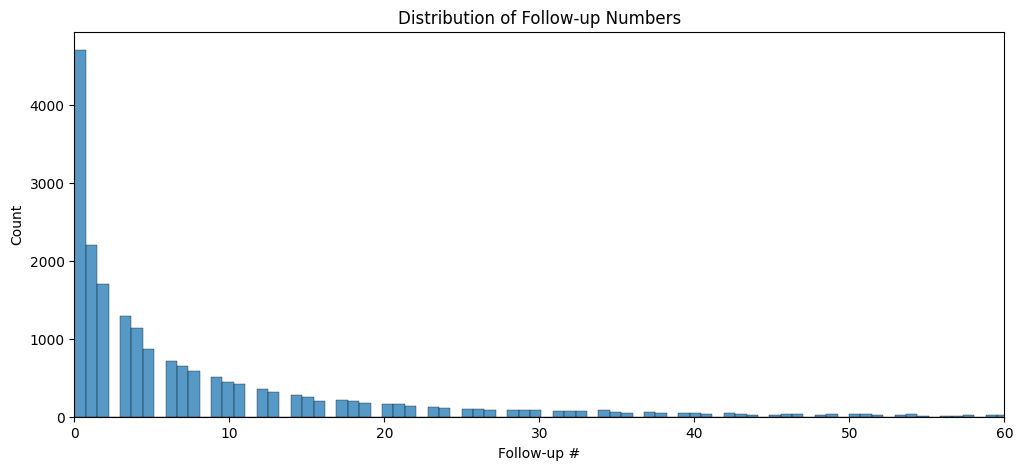

In [17]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=df, x="Follow-up #", ax=ax).set_title(
    'Distribution of Follow-up Numbers')
plt.xlim(0, 60)
plt.show()

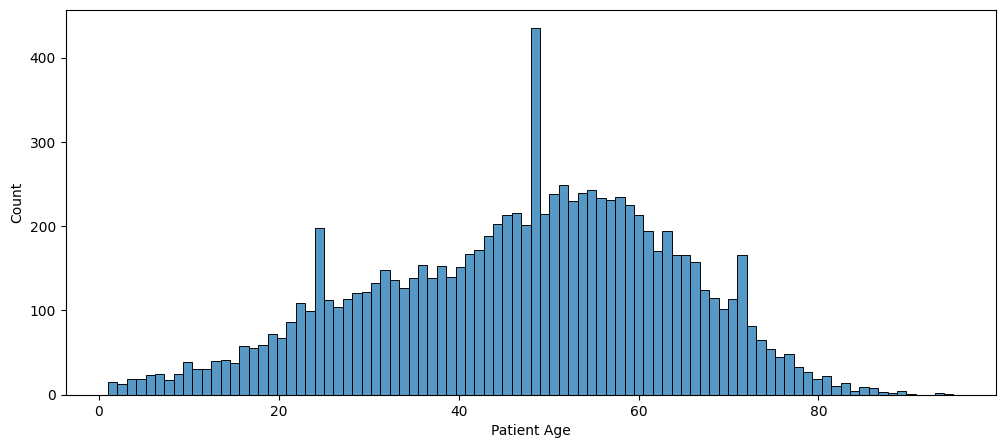

In [18]:
test = df.groupby("Patient ID").agg('first')

fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(test, x="Patient Age", ax=ax, bins=90)
plt.show()

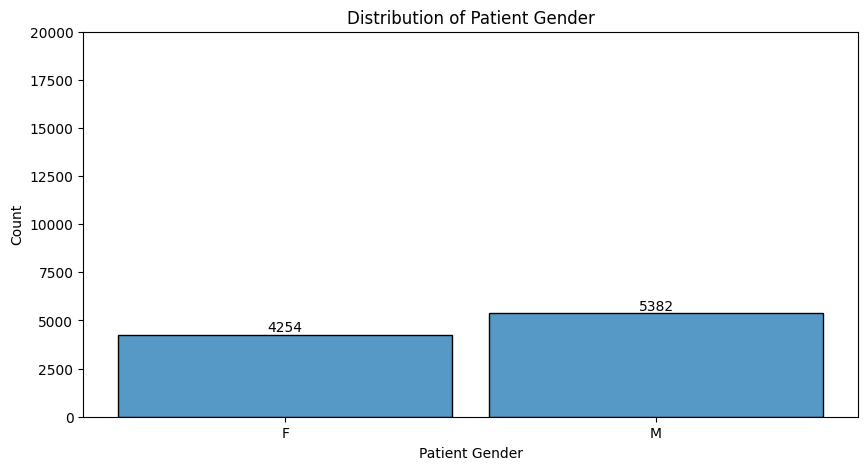

In [19]:
test = df.groupby("Patient ID").agg('first')

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(
    test,
    x="Patient Gender",
    discrete=True,
    ax=ax,
    shrink=.9).set_title("Distribution of Patient Gender")
ax.bar_label(ax.containers[0])
plt.ylim(0, 20000)
plt.show()

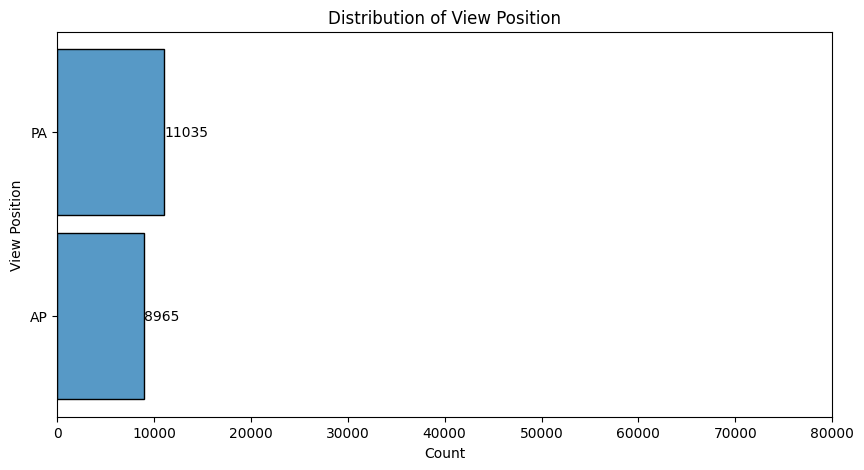

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(
    df, y='View Position', discrete=True, ax=ax, shrink=.9).set_title(
        "Distribution of View Position")
ax.bar_label(ax.containers[0])
plt.xlim(0, 80000)
plt.show()

## Feature relationships

In [21]:
cols_of_interest = [
    "Image Index", "Finding Labels", "Follow-up #", "Patient ID",
    "Patient Age", "Patient Gender", "View Position", 'Image Path'
]

df = df[cols_of_interest]

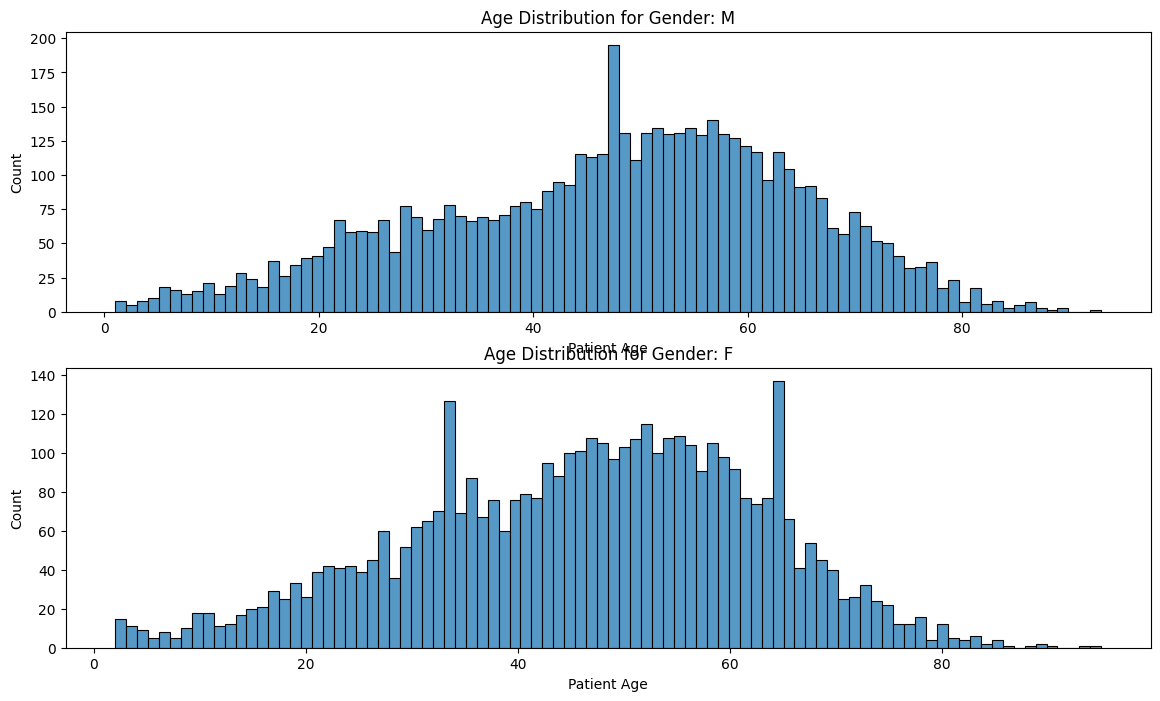

In [22]:
test = df.groupby("Patient ID").agg('first')
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

for i, val in enumerate(["M", "F"]):
    test1 = test[test['Patient Gender'] == val].reset_index()
    sns.histplot(test1, x="Patient Age", ax=axes[i], bins=90)
    axes[i].set_title(f"Age Distribution for Gender: {val}")

plt.show()

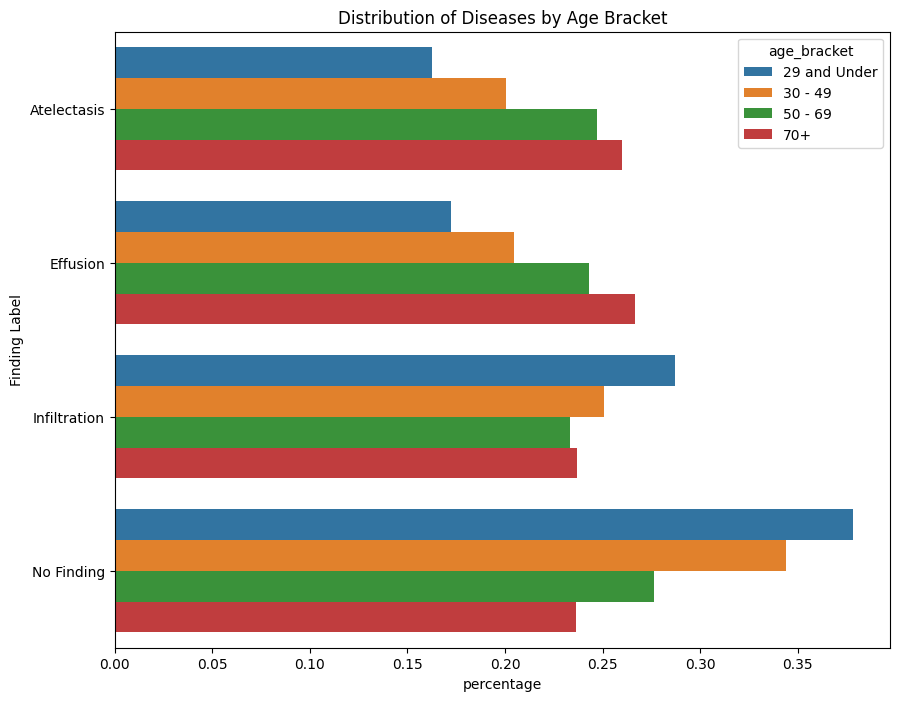

In [23]:
test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')

conditions = [
    (test['Patient Age'] <= 29),
    (test['Patient Age'] >= 30) & (test['Patient Age'] <= 49),
    (test['Patient Age'] >= 50) & (test['Patient Age'] <= 69),
    (test['Patient Age'] >= 70)
]

choices = ['29 and Under', '30 - 49', '50 - 69', '70+']
test['age_bracket'] = np.select(conditions, choices, default=np.nan)
test1 = test.groupby(
    ["age_bracket", "var1"]).size().sort_index().reset_index(name="count")
test2 = test1.groupby("age_bracket").sum("count").reset_index()

test1 = test1.merge(test2, on='age_bracket', suffixes=('', '_total'))
test1["percentage"] = test1["count"] / test1["count_total"]

plt.figure(figsize=(10, 8))
plt.title("Distribution of Diseases by Age Bracket")
ax = sns.barplot(
    y="var1",
    hue="age_bracket",
    x="percentage",
    data=test1,
    orient='h')
plt.ylabel("Finding Label")
plt.show()

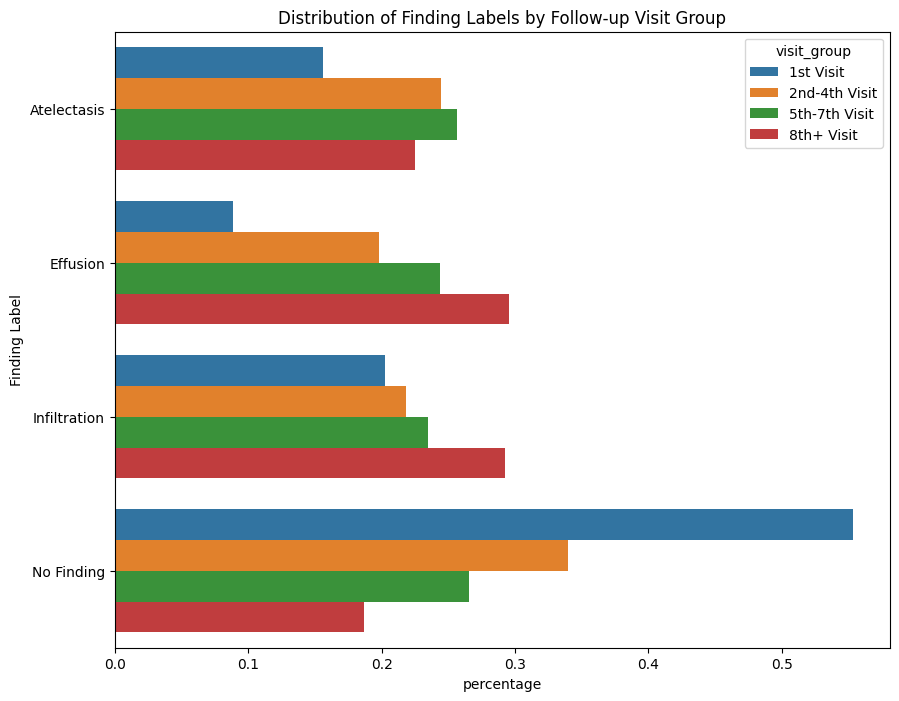

In [24]:
test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')

conditions = [
    (test['Follow-up #'] == 0),  # First visit
    (test['Follow-up #'] >= 1) & (test['Follow-up #'] <= 3),
    (test['Follow-up #'] >= 4) & (test['Follow-up #'] <= 6),
    (test['Follow-up #'] >= 7)
]

choices = ['1st Visit', '2nd-4th Visit', '5th-7th Visit', '8th+ Visit']
test['visit_group'] = np.select(conditions, choices, default=np.nan)
test1 = test.groupby(
    ["visit_group", "var1"]).size().sort_index().reset_index(name="count")
test2 = test1.groupby("visit_group").sum("count").reset_index()

test1 = test1.merge(test2, on='visit_group', suffixes=('', '_total'))
test1["percentage"] = test1["count"] / test1["count_total"]

plt.figure(figsize=(10, 8))
plt.title("Distribution of Finding Labels by Follow-up Visit Group")
ax = sns.barplot(
    y="var1", hue="visit_group", x="percentage", data=test1, orient='h')
plt.ylabel("Finding Label")
plt.show()

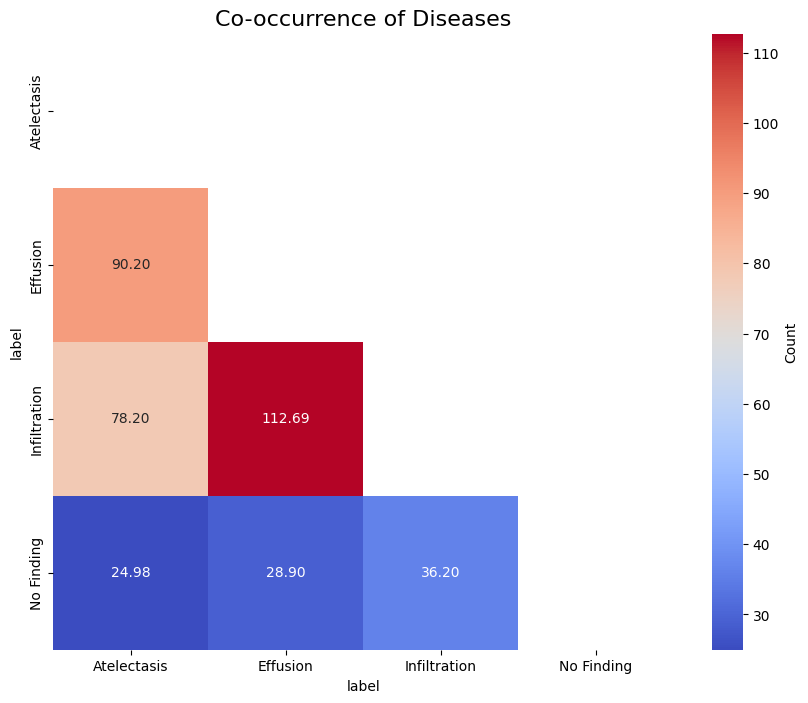

In [25]:
#Co-occurance heatmap
test = df.assign(label=df['Finding Labels'].str.split('|')).explode('label')
label_matrix = test.pivot_table(index="Patient ID", columns="label", aggfunc="size", fill_value=0)
co_occurrence_matrix = label_matrix.T.dot(label_matrix)
total_observations = len(df)
co_occurrence_matrix_percentage = (co_occurrence_matrix / total_observations) * 100
np.fill_diagonal(co_occurrence_matrix_percentage.values, 0)

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(co_occurrence_matrix_percentage, dtype=bool))
sns.heatmap(co_occurrence_matrix_percentage, mask=mask, cmap="coolwarm", annot=True, fmt=".2f", cbar_kws={'label': 'Count'})
plt.title("Co-occurrence of Diseases", fontsize=16)
plt.show()

<ipython-input-26-50aa7fd82b3b>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label Type', y='Count', data=label_totals, palette='viridis')


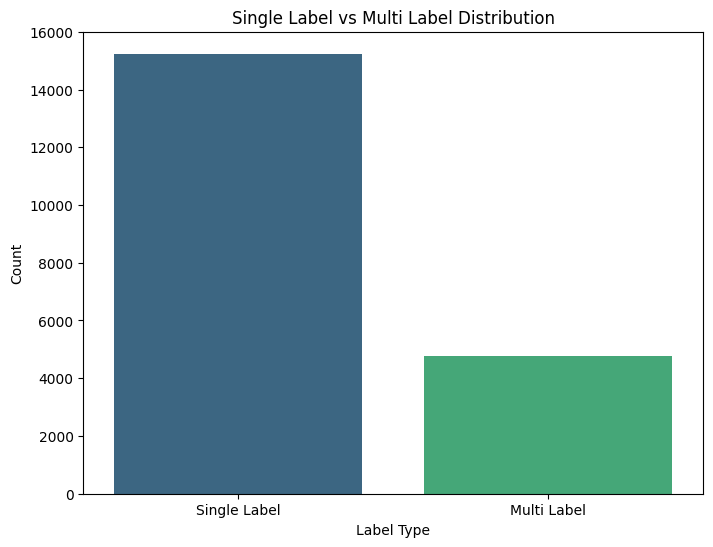

In [26]:
# Single vs. Multilabel
df['is_multilabel'] = df['Finding Labels'].str.contains(r'\|')
single_label_count = df[~df['is_multilabel']].shape[0]
multi_label_count = df[df['is_multilabel']].shape[0]

label_totals = pd.DataFrame({
    'Label Type': ['Single Label', 'Multi Label'],
    'Count': [single_label_count, multi_label_count]
})
plt.figure(figsize=(8, 6))
sns.barplot(x='Label Type', y='Count', data=label_totals, palette='viridis')
plt.title('Single Label vs Multi Label Distribution')
plt.xlabel('Label Type')
plt.ylabel('Count')
plt.show()

In [27]:
# Check if each entry is single-label or multi-label
df['is_multilabel'] = df['Finding Labels'].str.contains(r'\|')
single_label_count = df[~df['is_multilabel']].shape[0]
multi_label_count = df[df['is_multilabel']].shape[0]
label_totals = pd.DataFrame({
    'Label Type': ['Single Label', 'Multi Label'],
    'Count': [single_label_count, multi_label_count]
})

# Display table
label_totals

,Label Type,Count
0,Single Label,15240
1,Multi Label,4760


<ipython-input-28-8fa5733ecea8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["tags"] = df_filtered["Finding Labels"].str.split("|")
<ipython-input-28-8fa5733ecea8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["tags"] = df_filtered["tags"].apply(lambda x: sorted(x))


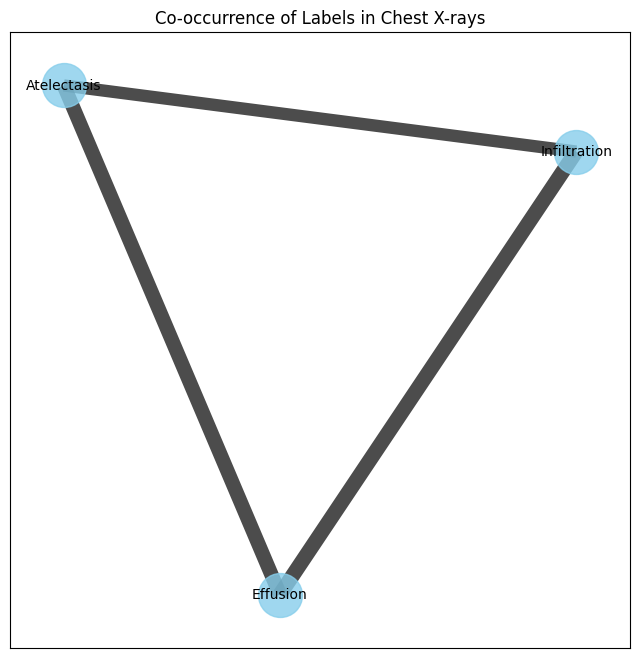

In [28]:
# Preprocessing: Filtering for images with exactly two labels
df_filtered = df[df["Finding Labels"].str.count(r'\|') == 1]
df_filtered["tags"] = df_filtered["Finding Labels"].str.split("|")
df_filtered["tags"] = df_filtered["tags"].apply(lambda x: sorted(x))

# Getting unique labels
all_tags = np.unique(np.concatenate(df_filtered['tags'].values))

# Helper function to add edge weight
def add_edge_weight(head, tail, graph):
    try:
        graph[head][tail]['weight'] += 1
    except:
        graph.add_edge(head, tail, weight=1)

# Initializing the graph
G = nx.Graph()

# Adding nodes (tags)
for t in all_tags:
    G.add_node(t)

# Adding edges (co-occurring tags)
for _, row in df_filtered.iterrows():
    tags = row['tags']
    add_edge_weight(tags[0], tags[1], G)

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, k=1.5)  # Adjust k for spacing

# Calculating total edge weights
w_sum = sum([data['weight'] for (_, _, data) in G.edges(data=True)])

# Drawing edges with varying width based on weight
for (node1, node2, data) in G.edges(data=True):
    width = data["weight"] * len(G.nodes) * 10.0 / w_sum
    nx.draw_networkx_edges(
        G, pos, edgelist=[(node1, node2)], width=width, alpha=0.7)

nx.draw_networkx_nodes(
    G, pos, node_size=1000, node_color='skyblue', alpha=0.8)

# Drawing labels without overlap
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
plt.title("Co-occurrence of Labels in Chest X-rays")
plt.show()

## Visualizing images with bounding boxes

        Image Index Finding Label     Bbox [x           y          w  \
0  00013118_008.png   Atelectasis  225.084746  547.019217  86.779661   

          h]  Unnamed: 6  Unnamed: 7  Unnamed: 8  
0  79.186441         NaN         NaN         NaN  


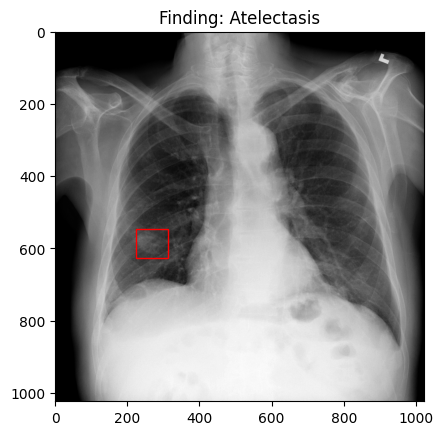

In [29]:
bbox_df = pd.read_csv(drive_path + "BBox_List_2017.csv")

print(bbox_df.head(1))
# Load the first image from dataframe
image_path = drive_path + "images_006/images/" + bbox_df['Image Index'][0]
image = Image.open(image_path)
x = bbox_df['Bbox [x'][0]
y = bbox_df['y'][0]
w = bbox_df['w'][0]
h = bbox_df['h]'][0]

fig, ax = plt.subplots(1)
ax.imshow(image, cmap='gray')

# Create rectangle
rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the img
ax.add_patch(rect)

plt.title(f"Finding: {bbox_df['Finding Label'][0]}")
plt.show()

## Target One Hot Encoding

In [30]:
# create list of targets
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

In [31]:
mlb = MultiLabelBinarizer()

ohe_target = mlb.fit_transform(df['Finding Labels'])
ohe_df = pd.DataFrame(ohe_target, columns=mlb.classes_)

target_cols = ohe_df.columns.to_list()

In [32]:
df = pd.concat([df, ohe_df], axis=1)
df.drop(columns='Finding Labels', inplace=True)
# df.columns = df.columns.str.replace(' ', '_')

df.head()

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Image Path,is_multilabel,Atelectasis,Effusion,Infiltration,No Finding
0,00025303_012.png,12,25303,63,F,PA,/content/drive/MyDrive/AAI-590 Capstone/images...,False,1,0,0,0
1,00002019_001.png,1,2019,35,F,PA,/content/drive/MyDrive/AAI-590 Capstone/images...,False,0,0,1,0
2,00028924_001.png,1,28924,72,F,PA,/content/drive/MyDrive/AAI-590 Capstone/images...,False,1,0,0,0
3,00019550_014.png,14,19550,9,F,AP,/content/drive/MyDrive/AAI-590 Capstone/images...,True,1,0,1,0
4,00006888_000.png,0,6888,32,F,PA,/content/drive/MyDrive/AAI-590 Capstone/images...,False,0,0,0,1


## Feature Label Encoding

In [33]:
le_gender = LabelEncoder()
le_view_position = LabelEncoder()

df['Patient Gender'] = le_gender.fit_transform(df['Patient Gender'])
df['View Position'] = le_view_position.fit_transform(df['View Position'])

In [34]:
df.head()

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Image Path,is_multilabel,Atelectasis,Effusion,Infiltration,No Finding
0,00025303_012.png,12,25303,63,0,1,/content/drive/MyDrive/AAI-590 Capstone/images...,False,1,0,0,0
1,00002019_001.png,1,2019,35,0,1,/content/drive/MyDrive/AAI-590 Capstone/images...,False,0,0,1,0
2,00028924_001.png,1,28924,72,0,1,/content/drive/MyDrive/AAI-590 Capstone/images...,False,1,0,0,0
3,00019550_014.png,14,19550,9,0,0,/content/drive/MyDrive/AAI-590 Capstone/images...,True,1,0,1,0
4,00006888_000.png,0,6888,32,0,1,/content/drive/MyDrive/AAI-590 Capstone/images...,False,0,0,0,1


In [35]:
df.to_csv(drive_path + 'final_dataset.csv')

# Modeling Prep - Train Test Split

In [36]:
df.columns

Index(['Image Index', 'Follow-up #', 'Patient ID', 'Patient Age',
       'Patient Gender', 'View Position', 'Image Path', 'is_multilabel',
       'Atelectasis', 'Effusion', 'Infiltration', 'No Finding'],
      dtype='object')

In [37]:
df = pd.read_csv(drive_path + 'final_dataset.csv')

In [38]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=1997)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=1997)

print(f'Training size: {len(train_df)}')
print(f'Validation size: {len(val_df)}')
print(f'Testing size: {len(test_df)}')

Training size: 16000
Validation size: 2000
Testing size: 2000


## Creating Datasets

In [39]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
CHANNELS = 1

def random_brightness(image):
    return tf.image.random_brightness(image, max_delta=0.1)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.005),
    tf.keras.layers.RandomContrast(0.005),
    tf.keras.layers.RandomTranslation(0.005, 0.005),
    tf.keras.layers.RandomZoom(0.005)
])

def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = data_augmentation(image)
    return image

def image_label_pairs(dataframe):
    image_paths = dataframe['Image Path'].values
    labels = dataframe.iloc[:, -4:].values
    return image_paths, labels

In [40]:
train_image_paths, train_labels = image_label_pairs(train_df)
val_image_paths, val_labels = image_label_pairs(val_df)
test_image_paths, test_labels = image_label_pairs(test_df)

In [41]:
def create_dataset(image_paths, labels, batch_size, shuffle=True, cache=True):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    image_ds = path_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.float32))
    dataset = tf.data.Dataset.zip((image_ds, label_ds))

    if cache:
        dataset = dataset.cache()

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [42]:
df.columns

Index(['Unnamed: 0', 'Image Index', 'Follow-up #', 'Patient ID', 'Patient Age',
       'Patient Gender', 'View Position', 'Image Path', 'is_multilabel',
       'Atelectasis', 'Effusion', 'Infiltration', 'No Finding'],
      dtype='object')

In [43]:
batch_size = 18
train_dataset = create_dataset(train_image_paths, train_labels, batch_size)
val_dataset = create_dataset(val_image_paths, val_labels, batch_size, shuffle=False)
test_dataset = create_dataset(test_image_paths, test_labels, batch_size, shuffle=False)

# Custom CNN

In [44]:
# verify GPU availability
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU is not available.")

GPU is available.


**No Regularization**

In [45]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(4, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
# Compile the model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [47]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

In [48]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[model_checkpoint],
    verbose=1
)

Epoch 1/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 192s 28ms/step - accuracy: 0.3994 - loss: 0.6103 - val_accuracy: 0.3985 - val_loss: 0.5854
Epoch 2/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.4283 - loss: 0.5759 - val_accuracy: 0.4335 - val_loss: 0.5740
Epoch 3/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4555 - loss: 0.5549 - val_accuracy: 0.4675 - val_loss: 0.5804
Epoch 4/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.4908 - loss: 0.5259 - val_accuracy: 0.4465 - val_loss: 0.5703
Epoch 5/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5404 - loss: 0.4748 - val_accuracy: 0.4680 - val_loss: 0.5883
Epoch 6/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6296 - loss: 0.3884 - val_accuracy: 0.4190 - val_loss: 0.6911
Epoch 7/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7291 - loss: 0.2595 - val_accuracy: 0.4250 - val_loss: 0.8458
Epoch 8/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8107 - loss: 0.1385 - val_accur

In [49]:
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

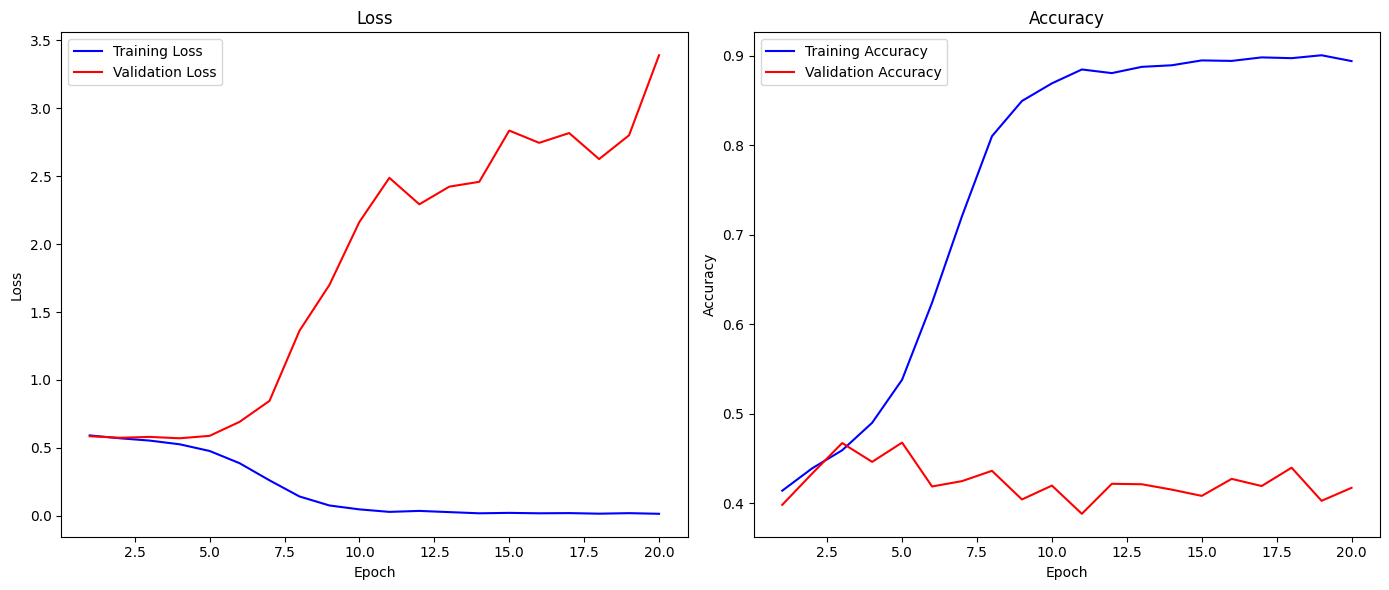

In [50]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Dropout Regularization**

In [51]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout layer
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout layer
    Dense(4, activation='sigmoid')
])

In [52]:
# Compile the model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [53]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[model_checkpoint],
    verbose=1
)

Epoch 1/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.3776 - loss: 0.6986 - val_accuracy: 0.3410 - val_loss: 0.6029
Epoch 2/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4252 - loss: 0.5833 - val_accuracy: 0.4120 - val_loss: 0.5873
Epoch 3/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4349 - loss: 0.5753 - val_accuracy: 0.4115 - val_loss: 0.5856
Epoch 4/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4405 - loss: 0.5697 - val_accuracy: 0.3915 - val_loss: 0.5848
Epoch 5/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4468 - loss: 0.5618 - val_accuracy: 0.3665 - val_loss: 0.5822
Epoch 6/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4542 - loss: 0.5537 - val_accuracy: 0.4135 - val_loss: 0.5748
Epoch 7/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4798 - loss: 0.5370 - val_accuracy: 0.4490 - val_loss: 0.5724
Epoch 8/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4925 - loss: 0.5258 - val_accuracy: 

In [54]:
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

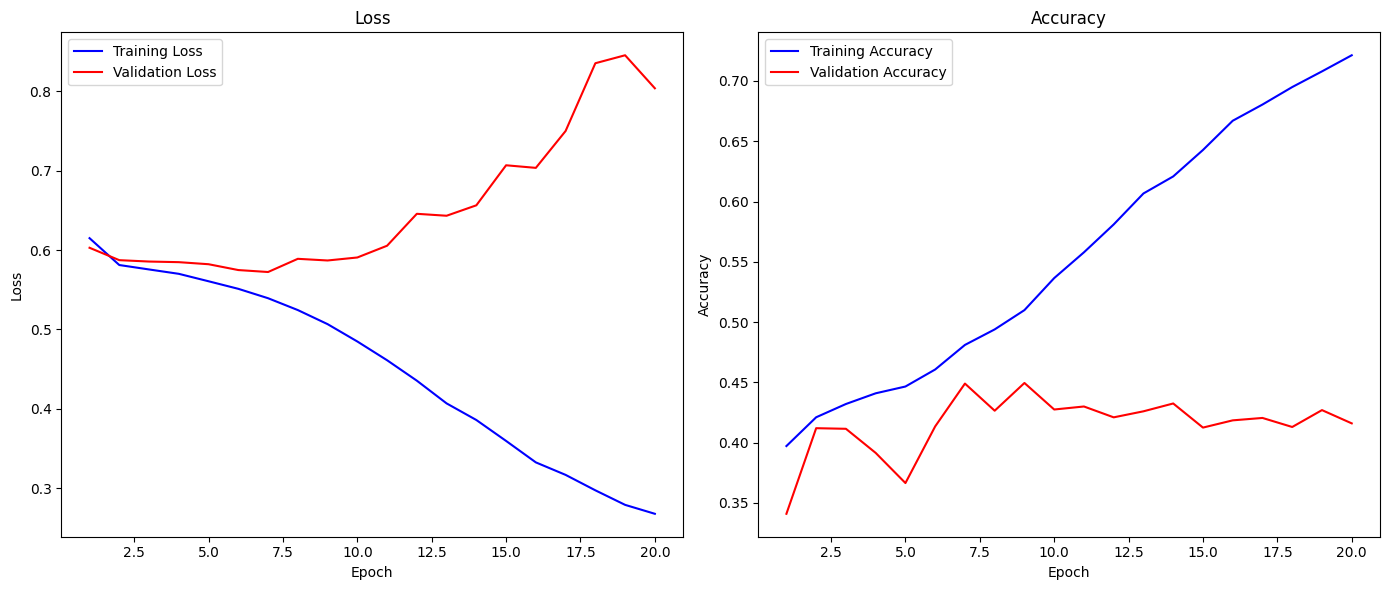

In [55]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**L2 Regularization**

In [56]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(4, activation='sigmoid')
])

In [57]:
# Compile the model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [58]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[model_checkpoint],
    verbose=1
)

Epoch 1/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.3480 - loss: 1.2593 - val_accuracy: 0.4035 - val_loss: 0.6310
Epoch 2/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3988 - loss: 0.6198 - val_accuracy: 0.3985 - val_loss: 0.6243
Epoch 3/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.4057 - loss: 0.6219 - val_accuracy: 0.3985 - val_loss: 0.6238
Epoch 4/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.3999 - loss: 0.6243 - val_accuracy: 0.3985 - val_loss: 0.6231
Epoch 5/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.4044 - loss: 0.6225 - val_accuracy: 0.3985 - val_loss: 0.6233
Epoch 6/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3969 - loss: 0.6244 - val_accuracy: 0.3985 - val_loss: 0.6234
Epoch 7/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.4023 - loss: 0.6242 - val_accuracy: 0.3985 - val_loss: 0.6232
Epoch 8/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3964 - loss: 0.6249 - val_accu

In [59]:
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

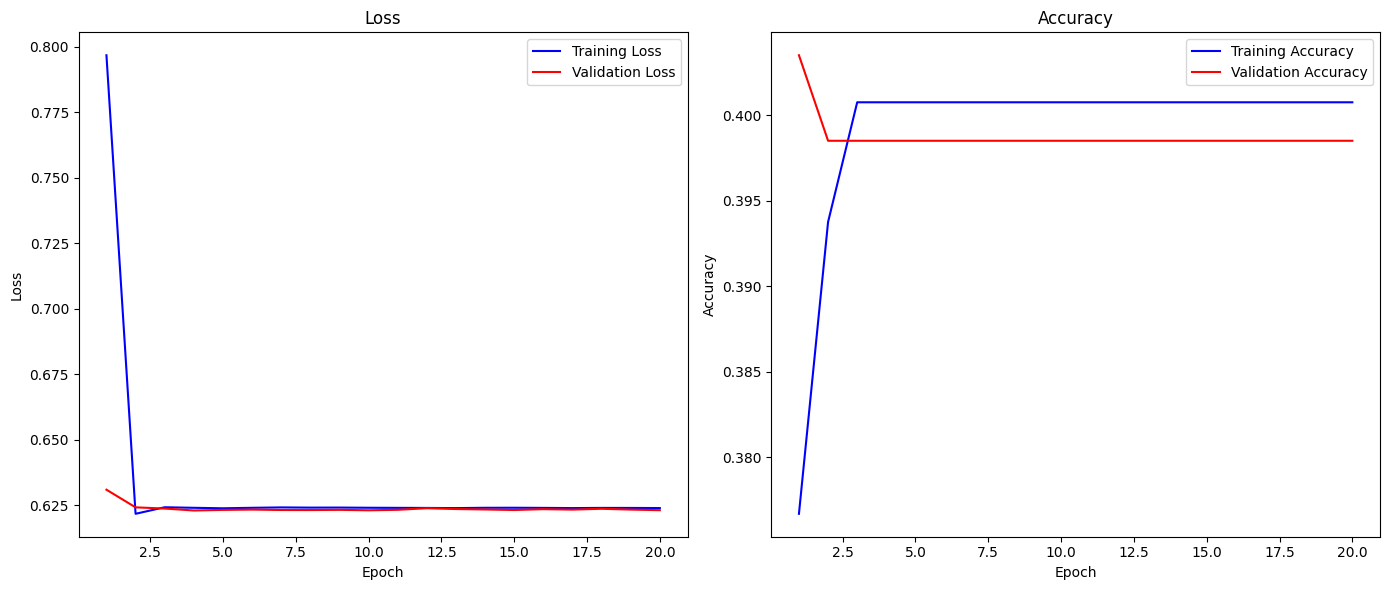

In [60]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Weaker L2 Regularization**

In [61]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS), kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(4, activation='sigmoid')
])

In [62]:
# Compile the model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [63]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[model_checkpoint],
    verbose=1
)

Epoch 1/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.3739 - loss: 0.7346 - val_accuracy: 0.4265 - val_loss: 0.6081
Epoch 2/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.4032 - loss: 0.6043 - val_accuracy: 0.4335 - val_loss: 0.5937
Epoch 3/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.4048 - loss: 0.5962 - val_accuracy: 0.4070 - val_loss: 0.6179
Epoch 4/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.4038 - loss: 0.5947 - val_accuracy: 0.3175 - val_loss: 0.6172
Epoch 5/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4115 - loss: 0.5912 - val_accuracy: 0.4410 - val_loss: 0.5896
Epoch 6/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.4202 - loss: 0.5893 - val_accuracy: 0.4230 - val_loss: 0.5932
Epoch 7/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.4102 - loss: 0.5874 - val_accuracy: 0.4510 - val_loss: 0.5926
Epoch 8/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.4229 - loss: 0.5869 - val_accu

In [64]:
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

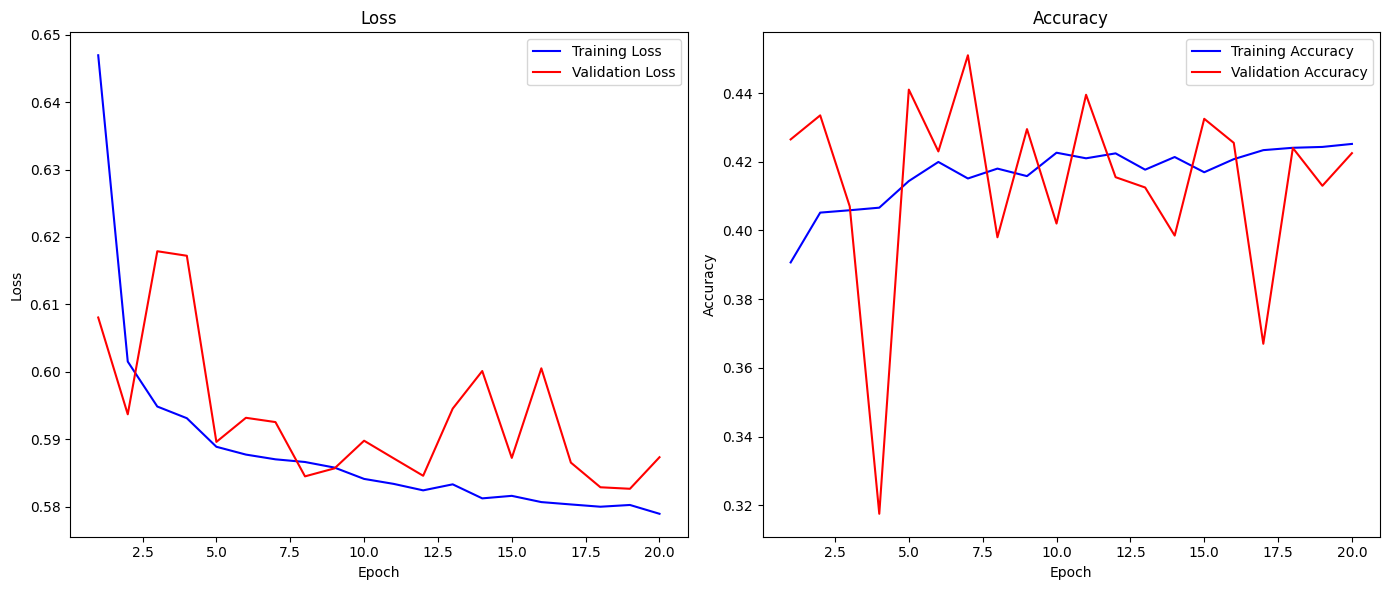

In [65]:
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Adding Dropout + Addtional Complexity**

In [66]:


# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(.5),

    Dense(4, activation='sigmoid')
])

In [67]:
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [68]:
# Define the learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.001)

In [69]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[model_checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 43s 31ms/step - accuracy: 0.3346 - loss: 0.7797 - val_accuracy: 0.3910 - val_loss: 0.5812 - learning_rate: 0.0010
Epoch 2/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.4050 - loss: 0.6000 - val_accuracy: 0.4490 - val_loss: 0.5807 - learning_rate: 0.0010
Epoch 3/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.4300 - loss: 0.5841 - val_accuracy: 0.4190 - val_loss: 0.5779 - learning_rate: 0.0010
Epoch 4/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.4323 - loss: 0.5744 - val_accuracy: 0.4580 - val_loss: 0.5728 - learning_rate: 0.0010
Epoch 5/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.4463 - loss: 0.5699 - val_accuracy: 0.4520 - val_loss: 0.5805 - learning_rate: 0.0010
Epoch 6/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.4421 - loss: 0.5703 - val_accuracy: 0.4250 - val_loss: 0.5765 - learning_rate: 0.0010
Epoch 7/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.4422 - l

In [70]:
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

In [71]:
model.save('best_model_complete.keras')

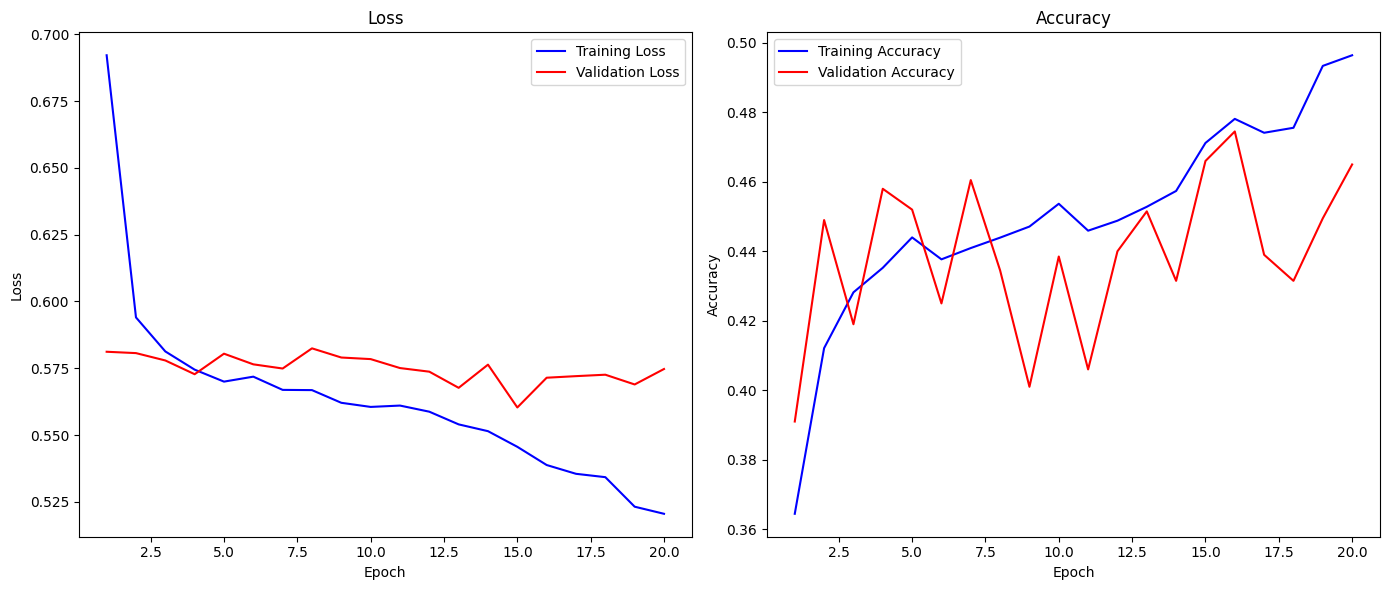

In [72]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [73]:
# Load and evaluate the best model
model = tf.keras.models.load_model('best_model.keras')
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = model.predict(test_dataset)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

target_labels = ['No Finding', 'Infiltration', 'Effusion', 'Atelectasis']

y_pred_binary = (y_pred > 0.3).astype(int)
print(classification_report(y_true, y_pred_binary, target_names=target_labels))

# Calculate AUC-ROC for each class
auc_roc = roc_auc_score(y_true, y_pred, average=None)
for i, label in enumerate(target_labels):
    print(f"{label}: AUC-ROC = {auc_roc[i]:.4f}")

# Calculate macro and micro average AUC-ROC
macro_auc_roc = roc_auc_score(y_true, y_pred, average='macro')
micro_auc_roc = roc_auc_score(y_true, y_pred, average='micro')
print(f"Macro AUC-ROC: {macro_auc_roc:.4f}")
print(f"Micro AUC-ROC: {micro_auc_roc:.4f}")

112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.4482 - loss: 0.5670
Test Loss: 0.5599074959754944
Test Accuracy: 0.453000009059906
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
              precision    recall  f1-score   support

  No Finding       0.44      0.64      0.52       572
Infiltration       0.55      0.65      0.60       576
    Effusion       0.42      0.56      0.48       663
 Atelectasis       0.51      0.87      0.64       791

   micro avg       0.48      0.69      0.57      2602
   macro avg       0.48      0.68      0.56      2602
weighted avg       0.48      0.69      0.57      2602
 samples avg       0.51      0.69      0.56      2602

No Finding: AUC-ROC = 0.7183
Infiltration: AUC-ROC = 0.7989
Effusion: AUC-ROC = 0.6236
Atelectasis: AUC-ROC = 0.7306
Macro AUC-ROC: 0.7178
Micro AUC-ROC: 0.7266


## Keras-Tuner

In [74]:
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('conv1_units', min_value=32, max_value=128, step=32),
                     (3, 3),
                     activation=hp.Choice('activation', values=['relu', 'leaky_relu', 'elu']),
                     input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Float('dropout1', 0.2, 0.6, step=0.1)))

    for i in range(hp.Int('num_conv_layers', 2, 4)):
        model.add(Conv2D(hp.Int(f'conv{i+2}_units', min_value=32, max_value=128, step=32),
                         (3, 3),
                         activation=hp.Choice('activation', values=['relu', 'leaky_relu', 'elu'])))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(hp.Float(f'dropout_conv{i+2}', 0.2, 0.6, step=0.1)))

    model.add(Flatten())

    for i in range(hp.Int('num_dense_layers', 1, 3)):
        model.add(Dense(hp.Int(f'dense{i+1}_units', min_value=128, max_value=512, step=128),
                        activation=hp.Choice('activation', values=['relu', 'leaky_relu', 'elu'])))
        model.add(Dropout(hp.Float(f'dropout_dense{i+1}', 0.2, 0.6, step=0.1)))

    model.add(Dense(4, activation='sigmoid'))

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

# Instantiate the tuner with RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=15,
    directory='my_dir',
    project_name='chest_xray_classification',
    distribution_strategy=tf.distribute.MirroredStrategy()
)

tuner.search_space_summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('tuned_model.keras', save_best_only=True, monitor='val_loss')

tuner.search(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping, model_checkpoint])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first convolutional layer is {best_hps.get('conv1_units')},
the optimal number of convolutional layers is {best_hps.get('num_conv_layers')},
the optimal number of units in the dense layers is {best_hps.get('dense1_units')},
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


Trial 15 Complete [00h 03m 05s]
val_loss: 1.125291347503662

Best val_loss So Far: 0.5537167191505432
Total elapsed time: 01h 36m 23s

The hyperparameter search is complete. The optimal number of units in the first convolutional layer is 64,
the optimal number of convolutional layers is 3,
the optimal number of units in the dense layers is 128,
and the optimal learning rate for the optimizer is 0.001.



In [85]:
# Build and train the model with the best hyperparameters
target_labels = ['No Finding', 'Infiltration', 'Effusion', 'Atelectasis']

model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping, model_checkpoint]
)
model.load_weights('tuned_model.keras')

test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = model.predict(test_dataset)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

y_pred_binary = (y_pred > 0.3).astype(int)
print(classification_report(y_true, y_pred_binary, target_names=target_labels))

# Calculate AUC-ROC for each class
auc_roc = roc_auc_score(y_true, y_pred, average=None)
for i, label in enumerate(target_labels):
    print(f"{label}: AUC-ROC = {auc_roc[i]:.4f}")

# Calculate macro and micro average AUC-ROC
macro_auc_roc = roc_auc_score(y_true, y_pred, average='macro')
micro_auc_roc = roc_auc_score(y_true, y_pred, average='micro')
print(f"Macro AUC-ROC: {macro_auc_roc:.4f}")
print(f"Micro AUC-ROC: {micro_auc_roc:.4f}")

Epoch 1/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.3420 - loss: 0.7446 - val_accuracy: 0.4110 - val_loss: 0.5870
Epoch 2/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.4024 - loss: 0.6054 - val_accuracy: 0.3935 - val_loss: 0.5892
Epoch 3/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.4325 - loss: 0.5816 - val_accuracy: 0.4500 - val_loss: 0.5752
Epoch 4/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.4458 - loss: 0.5704 - val_accuracy: 0.4265 - val_loss: 0.5884
Epoch 5/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.4388 - loss: 0.5647 - val_accuracy: 0.4380 - val_loss: 0.5643
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4732 - loss: 0.5575
Test Loss: 0.5526456236839294
Test Accuracy: 0.476500004529953
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

  No Finding       0.42      0.72      0.53       572
Infiltration       0.53      0.74      0.62       576
    Effusion

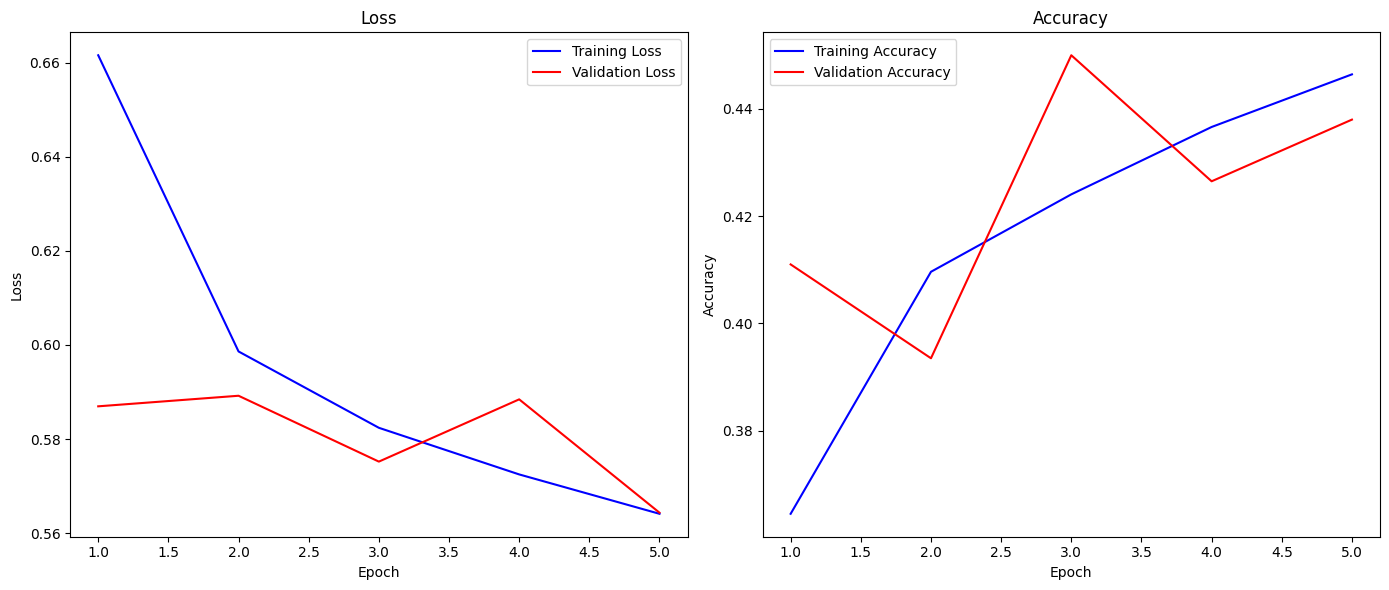

In [86]:
# Plotting the training and validation loss and accuracy
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

##VGG16 Pretrained Model

In [87]:
# Changing the input layer to accept 1-channel (grayscale)
new_input = Input(shape=(256, 256, 1))
x = Conv2D(3, (3, 3), padding='same')(new_input)

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
vgg16_output = vgg16(x)
add_model = Sequential()
add_model.add(Flatten(input_shape=vgg16_output.shape[1:]))
add_model.add(Dropout(0.2))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dropout(0.2))
add_model.add(Dense(4, activation='sigmoid'))

model_vgg16 = Model(inputs=new_input, outputs=add_model(vgg16_output))
model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_vgg16.keras', save_best_only=True, monitor='val_loss')

# Train
history_vgg16 = model_vgg16.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


889/889 ━━━━━━━━━━━━━━━━━━━━ 50s 49ms/step - accuracy: 0.3577 - loss: 0.6323 - val_accuracy: 0.3970 - val_loss: 0.6035
Epoch 2/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4068 - loss: 0.5919 - val_accuracy: 0.4550 - val_loss: 0.5649
Epoch 3/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4565 - loss: 0.5643 - val_accuracy: 0.4630 - val_loss: 0.5501
Epoch 4/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4723 - loss: 0.5461 - val_accuracy: 0.5030 - val_loss: 0.5352
Epoch 5/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 38s 43ms/step - accuracy: 0.4922 - loss: 0.5253 - val_accuracy: 0.4715 - val_loss: 0.5369
Epoch 6/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4958 - loss: 0.5204 - val_accuracy: 0.5185 - val_loss: 0.5205
Epoch 7/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 38s 43ms/step - accuracy: 0.5065 - loss: 0.5089 - val_accuracy: 0.5080 - val_loss: 0.5281
Epoch 8/20
889/889 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.5204 - loss: 0.4987 - val_accurac

In [88]:
# Load and evaluate the VGG16 model
model_vgg16.load_weights('best_model_vgg16.keras')
test_loss_vgg16, test_accuracy_vgg16 = model_vgg16.evaluate(test_dataset)
print(f"VGG16 Test Loss: {test_loss_vgg16}")
print(f"VGG16 Test Accuracy: {test_accuracy_vgg16}")

# Predict on the test dataset
y_pred_vgg16 = model_vgg16.predict(test_dataset)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred_binary_vgg16 = (y_pred_vgg16 > 0.3).astype(int)
print(classification_report(y_true, y_pred_binary_vgg16, target_names=target_labels))

# Calculate AUC-ROC for each class
auc_roc_vgg16 = roc_auc_score(y_true, y_pred_vgg16, average=None)
for i, label in enumerate(target_labels):
    print(f"{label}: AUC-ROC = {auc_roc_vgg16[i]:.4f}")

# Calculate macro and micro average AUC-ROC
macro_auc_roc_vgg16 = roc_auc_score(y_true, y_pred_vgg16, average='macro')
micro_auc_roc_vgg16 = roc_auc_score(y_true, y_pred_vgg16, average='micro')
print(f"Macro AUC-ROC: {macro_auc_roc_vgg16:.4f}")
print(f"Micro AUC-ROC: {micro_auc_roc_vgg16:.4f}")

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5055 - loss: 0.5229
VGG16 Test Loss: 0.5203605890274048
VGG16 Test Accuracy: 0.4975000023841858
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
              precision    recall  f1-score   support

  No Finding       0.47      0.71      0.56       572
Infiltration       0.60      0.83      0.70       576
    Effusion       0.41      0.69      0.52       663
 Atelectasis       0.57      0.81      0.67       791

   micro avg       0.51      0.76      0.61      2602
   macro avg       0.51      0.76      0.61      2602
weighted avg       0.51      0.76      0.61      2602
 samples avg       0.53      0.75      0.60      2602

No Finding: AUC-ROC = 0.7550
Infiltration: AUC-ROC = 0.8690
Effusion: AUC-ROC = 0.6459
Atelectasis: AUC-ROC = 0.7720
Macro AUC-ROC: 0.7605
Micro AUC-ROC: 0.7753


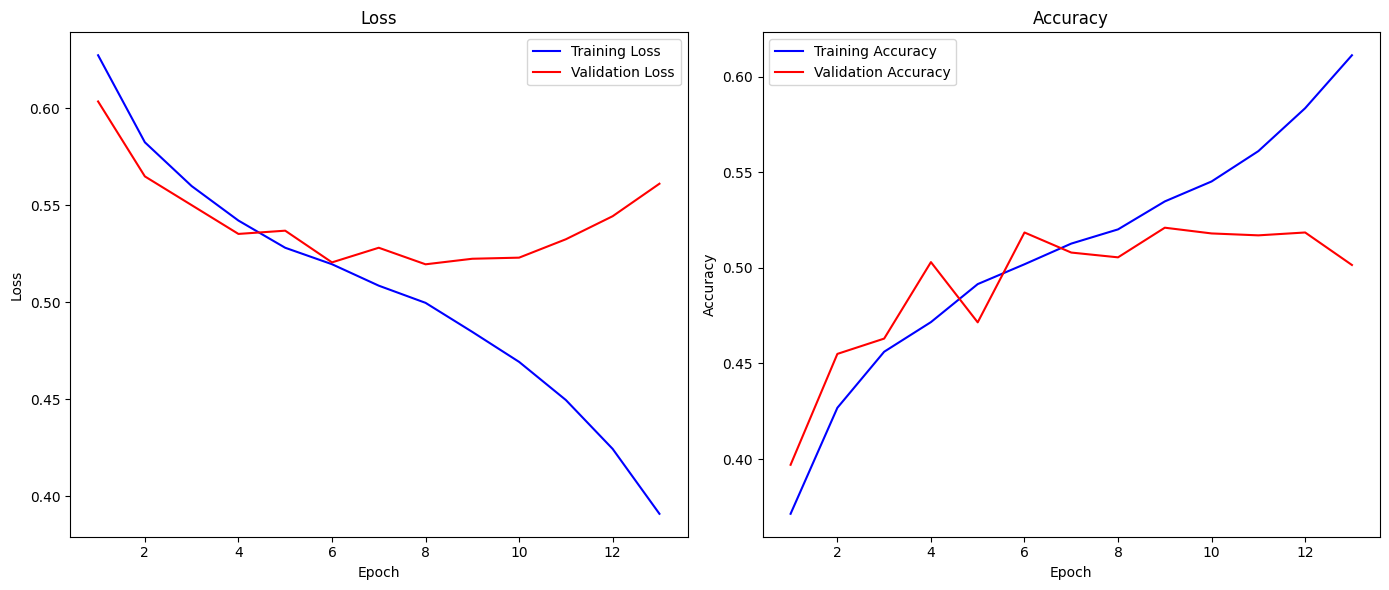

In [89]:
# Plotting the training and validation loss and accuracy
epochs = range(1, len(history_vgg16.history['loss']) + 1)
train_loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']
train_accuracy = history_vgg16.history['accuracy']
val_accuracy = history_vgg16.history['val_accuracy']

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Weighted Average Ensemble

In [100]:
model_vgg16 = tf.keras.models.load_model('best_model_vgg16.keras')
model_keras_tuned = tf.keras.models.load_model('tuned_model.keras')
model_best = tf.keras.models.load_model('best_model.keras')

y_pred_vgg16 = model_vgg16.predict(test_dataset)
y_pred_keras_tuned = model_keras_tuned.predict(test_dataset)
y_pred_best = model_best.predict(test_dataset)

# Averaging the predictions with the specified weights
y_pred_ensemble = (0.70 * y_pred_vgg16) + (0.25 * y_pred_keras_tuned) + (0.05 * y_pred_best)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred_binary_ensemble = (y_pred_ensemble > 0.3).astype(int)

target_labels = ['No Finding', 'Infiltration', 'Effusion', 'Atelectasis']

print(classification_report(y_true, y_pred_binary_ensemble, target_names=target_labels))

# Calculate AUC-ROC for each class
auc_roc_ensemble = roc_auc_score(y_true, y_pred_ensemble, average=None)
for i, label in enumerate(target_labels):
    print(f"{label}: AUC-ROC = {auc_roc_ensemble[i]:.4f}")

# Calculate macro and micro average AUC-ROC
macro_auc_roc_ensemble = roc_auc_score(y_true, y_pred_ensemble, average='macro')
micro_auc_roc_ensemble = roc_auc_score(y_true, y_pred_ensemble, average='micro')
print(f"Macro AUC-ROC: {macro_auc_roc_ensemble:.4f}")
print(f"Micro AUC-ROC: {micro_auc_roc_ensemble:.4f}")


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

  No Finding       0.46      0.71      0.56       572
Infiltration       0.60      0.83      0.70       576
    Effusion       0.42      0.70      0.53       663
 Atelectasis       0.56      0.84      0.67       791

   micro avg       0.51      0.78      0.61      2602
   macro avg       0.51      0.77      0.61      2602
weighted avg       0.51      0.78      0.61      2602
 samples avg       0.53      0.76      0.60      2602

No Finding: AUC-ROC = 0.7559
Infiltration: AUC-ROC = 0.8675
Effusion: AUC-ROC = 0.6468
Atelectasis: AUC-ROC = 0.7716
Macro AUC-ROC: 0.7605
Micro AUC-ROC: 0.7759
